In [40]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import isodate
import urltools
import urllib
from scipy.stats import mannwhitneyu
import re
import os.path
from langdetect import detect
import string
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import fastcluster
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from scipy.spatial.distance import squareform
import sys
from scipy.cluster.hierarchy import fcluster, dendrogram
from nltk.stem.porter import PorterStemmer
from ggplot import *
import utils
import warnings
warnings.filterwarnings('ignore')
sys.setrecursionlimit(100000)
matplotlib.style.use('ggplot')

## YouTube - Exploratory Analyses
### Loading the dataset
First, let us load the dataset from the database.

In [3]:
con = sqlite3.connect('../../crawler/YouTube/youtube.db')
video = pd.read_sql_query('''SELECT v.autoId as autoId, 
                                    v.id as id,
                                    v.categoryId as categoryId,
                                    v.channelId as channelId,
                                    v.publishedAt as publishedAt,
                                    v.title as title,
                                    v.description as description,
                                    v.viewCount as viewCount,
                                    v.likeCount as likeCount,
                                    v.dislikeCount as dislikeCount,
                                    v.favoriteCount as favoriteCount,
                                    v.commentCount as commentCount,
                                    v.duration as duration,
                                    v.defaultLanguage as defaultLanguage,
                                    c.title as channelTitle,
                                    c.description as channelDescription,
                                    c.publishedAt as channelPublishedAt,
                                    c.viewCount as channelViewCount,
                                    c.commentCount as channelCommentCount,
                                    c.subscriberCount as channelSubscriberCount,
                                    c.videoCount as channelVideoCount,
                                    c.country as channelCountry
                                    from video v left join channel c on v.channelId = c.id''', con)
url = pd.read_sql_query('SELECT * from urlNumber', con)
urlResolve = pd.read_sql_query('SELECT * from urlResolve', con)
category = pd.read_sql_query('SELECT * from category', con)
channel = pd.read_sql_query('SELECT * from channel', con)
captions = pd.read_sql_query('SELECT * FROM captions', con)

Next, let's examine the count of videos we collected. The tables are ``video``, ``url``, ``urlResolve``, and ``category``.

In [4]:
video.shape

(515999, 22)

In [5]:
list(video.columns.values)

['autoId',
 'id',
 'categoryId',
 'channelId',
 'publishedAt',
 'title',
 'description',
 'viewCount',
 'likeCount',
 'dislikeCount',
 'favoriteCount',
 'commentCount',
 'duration',
 'defaultLanguage',
 'channelTitle',
 'channelDescription',
 'channelPublishedAt',
 'channelViewCount',
 'channelCommentCount',
 'channelSubscriberCount',
 'channelVideoCount',
 'channelCountry']

In [6]:
url.shape

(405471, 4)

In [7]:
list(url.columns.values)

['autoId', 'videoId', 'url', 'lineNumber']

In [8]:
urlResolve.shape

(660009, 5)

In [9]:
list(urlResolve.columns.values)

['autoId', 'urlId', 'url', 'urlOrder', 'code']

In [10]:
category.shape

(32, 3)

In [11]:
list(category.columns.values)

['autoId', 'id', 'key']

### Examining the videos
Next, let's examine the categories of the videos.

In [12]:
category_dict = {}
for index, row in category.iterrows():
    category_dict[int(row['id'])] = row['key']
category_dict

{1: u'Film & Animation',
 2: u'Autos & Vehicles',
 10: u'Music',
 15: u'Pets & Animals',
 17: u'Sports',
 18: u'Short Movies',
 19: u'Travel & Events',
 20: u'Gaming',
 21: u'Videoblogging',
 22: u'People & Blogs',
 23: u'Comedy',
 24: u'Entertainment',
 25: u'News & Politics',
 26: u'Howto & Style',
 27: u'Education',
 28: u'Science & Technology',
 29: u'Nonprofits & Activism',
 30: u'Movies',
 31: u'Anime/Animation',
 32: u'Action/Adventure',
 33: u'Classics',
 34: u'Comedy',
 35: u'Documentary',
 36: u'Drama',
 37: u'Family',
 38: u'Foreign',
 39: u'Horror',
 40: u'Sci-Fi/Fantasy',
 41: u'Thriller',
 42: u'Shorts',
 43: u'Shows',
 44: u'Trailers'}

Set the "categoryId" column in ``video`` to ``category``'s key.

In [13]:
video['categoryId'] = video['categoryId'].replace(category_dict)

#### Video categories
How many videos do we have in each category?

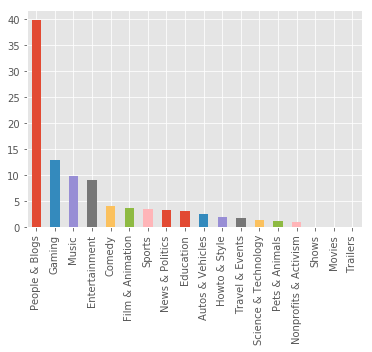

In [14]:
((video['categoryId'].value_counts() * 100) / len(video['categoryId'])).plot.bar()
plt.show()

#### Video creation times
When were these videos published?

In [15]:
video['publishedAt'] = pd.to_datetime(video['publishedAt']).dt.year

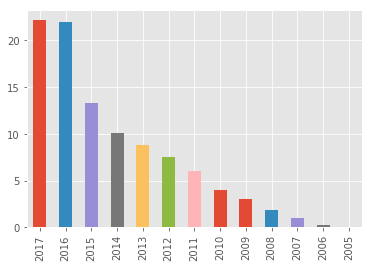

In [16]:
((video['publishedAt'].value_counts() * 100) / len(video['publishedAt'])).plot.bar()
plt.show()

#### Video views
How do the views vary?

In [17]:
video['viewCount'].describe()

count    5.159990e+05
mean     3.087055e+04
std      1.010419e+06
min      0.000000e+00
25%      1.100000e+01
50%      4.900000e+01
75%      3.100000e+02
max      2.876380e+08
Name: viewCount, dtype: float64

#### Video duration
How long are the videos?

In [18]:
video['duration'] = video['duration'].map(lambda x: isodate.parse_duration(x).total_seconds())
video['duration'].describe()

count    515999.000000
mean        445.870275
std        1201.335379
min           0.000000
25%          61.000000
50%         172.000000
75%         366.000000
max       86400.000000
Name: duration, dtype: float64

#### Video Channels

How many channels do these videos correspond to?

In [19]:
video['channelId'].duplicated().value_counts()

False    484172
True      31827
Name: channelId, dtype: int64

#### Video countries

Which countries are the channels from?

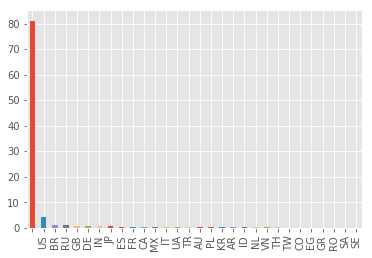

In [20]:
(video['channelCountry'].value_counts()[video['channelCountry'].value_counts() > 500] * 100 / len(video['channelCountry'])).plot.bar()
plt.show()

### Manipulating the URLs

Add functions that dissect the URL to reveal the various parts.

In [21]:
def manipulate_urls(x):
    parsed_url = urltools.parse(x.url)
    
    sd = parsed_url.subdomain.lower()
    if sd.startswith('www.'):
        sd = sd[4:]
    
    return pd.Series([parsed_url.domain.lower(), 
                      urllib.unquote(parsed_url.path).lower(),
                      sd,
                      urllib.unquote(parsed_url.query).lower()])

In [22]:
list(urlResolve.columns.values)

['autoId', 'urlId', 'url', 'urlOrder', 'code']

In [23]:
urlResolve[['urlDomain', 'urlPath', 'urlSubDomain', 'urlParams']] = urlResolve.apply(manipulate_urls, axis=1)

Mark all the following patterns as affiliate links.

In [24]:
def check_affiliate_link(x):
    params_list = map(lambda y: y.split('=')[0], x.urlParams.split('&'))
    regexp_clickbank = re.compile(r'.*.hop')
    regexp_anrdoezrs = re.compile(r'/click-[0-9]+-[0-9]+')
    regexp_buyeasy_1 = re.compile(r'/cashback.*')
    regexp_buyeasy_2 = re.compile(r'/redirect.*')
    regexp_admitad_1 = re.compile(r'/g/.*')
    regexp_admitad_2 = re.compile(r'/goto/.*')
    regexp_impactradius = re.compile(r'/c/[0-9]+/[0-9]+/[0-9]+')
    regexp_pepperjam = re.compile(r'/t/[0-9]-[0-9]+-[0-9]+-[0-9]+')
    
    if ((x.urlDomain == 'affiliaxe' and 'aff_id' in params_list) or
        (x.urlDomain == 'aliexpress' and 'af' in params_list) or
        (x.urlDomain == 'amazon' and 'tag' in params_list) or
        (x.urlDomain == 'apessay' and 'rid' in params_list) or
        (x.urlDomain == 'apple' and 'at' in params_list) or
        (x.urlDomain == 'audiojungle' and 'ref' in params_list) or
        (x.urlDomain == 'awin1' and 'awinaffid' in params_list) or
        (x.urlDomain == 'zanox' and x.urlPath == '/ppc') or
        (x.urlDomain == 'zenaps' and x.urlPath == '/rclick.php') or
        (x.urlDomain == 'banggood' and 'p' in params_list) or
        (x.urlDomain == 'bookdepository' and 'a_aid' in params_list) or
        (x.urlDomain == 'booking' and 'aid' in params_list) or
        (x.urlDomain == 'ebay' and 'campid' in params_list) or
        (x.urlDomain == 'envato' and 'ref' in params_list) or
        (x.urlDomain == 'gtomegaracing' and 'tracking' in params_list) or
        (x.urlDomain == 'hotellook' and 'marker' in params_list) or
        (x.urlDomain == 'hotmart' and 'a' in params_list) or
        (x.urlDomain == 'kontrolfreek' and 'a_aid' in params_list) or
        (x.urlDomain == 'shareasale' and x.urlPath == '/r.cfm') or
        (x.urlDomain == 'shareasale' and x.urlPath == '/m-pr.cfm') or
        (x.urlDomain == 'shareasale' and x.urlPath == '/u.cfm') or
        (x.urlDomain == 'rstyle') or
        (x.urlDomain == 'shopstyle') or
        (x.urlDomain == 'makeupgeek' and 'acc' in params_list) or
        (x.urlDomain == 'olymptrade' and 'affiliate_id' in params_list) or
        (x.urlDomain == 'videohive' and 'ref' in params_list) or
        (x.urlDomain == 'avantlink' and 'pw' in params_list) or
        (x.urlDomain == 'avangate' and 'AFFILIATE'.lower() in params_list) or
        (x.urlDomain == 'redirectingat' and 'id' in params_list) or
        (x.urlDomain == 'linksynergy' and x.urlSubDomain == 'click' and 'id' in params_list) or
        (x.urlDomain == 'audiobooks' and 'a_aid' in params_list and 'a_bid' in params_list) or
        (x.urlDomain == 'buyeasy' and regexp_buyeasy_1.search(x.urlPath)) or
        (x.urlDomain == 'buyeasy' and regexp_buyeasy_2.search(x.urlPath)) or
        (x.urlDomain == 'clickbank' and regexp_clickbank.search(x.urlSubDomain)) or
        
        ((x.urlDomain == '7eer' or x.urlDomain == 'evyy' or x.urlDomain == 'ojrq' ) and regexp_impactradius.search(x.urlPath)) or
        
        ((x.urlDomain == 'anrdoezrs' or x.urlDomain == 'dpbolvw' or x.urlDomain == 'kqzyfj' or x.urlDomain == 'jdoqocy' or x.urlDomain == 'tkqlhce') and regexp_anrdoezrs.search(x.urlPath)) or
        (x.urlDomain == 'emjcd') or
        (x.urlDomain == 'dotomi') or
        (x.urlDomain == 'qksrv') or
        
        (x.urlDomain == 'zaful' and 'lkid' in params_list) or
        (x.urlDomain == 'codecanyon' and 'ref' in params_list) or
        (x.urlDomain == 'graphicriver' and 'ref' in params_list) or
        (x.urlDomain == 'themeforest' and 'ref' in params_list) or
        (x.urlDomain == 'admitad' and (regexp_admitad_1.search(x.urlPath) or regexp_admitad_2.search(x.urlPath))) or
        (x.urlDomain == 'flipkart' and 'affid' in params_list) or
        
        ((x.urlDomain == 'pntra' or
        x.urlDomain == 'gopjn' or
        x.urlDomain == 'pjtra' or
        x.urlDomain == 'pjatr' or
        x.urlDomain == 'pntrs' or
        x.urlDomain == 'pntrac') and (regexp_pepperjam.search(x.urlPath)))
       ):
        
            return True
        
    return False

urlResolve['affiliateLink'] = urlResolve.apply(check_affiliate_link, axis=1)

How many of these resolved links were affiliate in nature?

In [25]:
urlResolve['affiliateLink'].value_counts()

False    643898
True      16111
Name: affiliateLink, dtype: int64

How did these resolved affiliate links vary by domain?

In [26]:
(urlResolve[urlResolve['affiliateLink'] == True]).groupby(['urlDomain'])['autoId'].count().sort_values(ascending=False)

urlDomain
amazon            7308
aliexpress        2167
buyeasy            741
clickbank          678
apple              669
videohive          578
rstyle             402
booking            257
admitad            245
hotmart            211
shareasale         199
linksynergy        189
envato             175
7eer               172
hotellook          165
affiliaxe          151
apessay            141
audiobooks         129
kontrolfreek       117
dotomi             115
shopstyle          111
audiojungle        108
bookdepository     103
emjcd              103
ebay                99
banggood            88
flipkart            81
awin1               70
olymptrade          65
zenaps              59
makeupgeek          57
gtomegaracing       56
anrdoezrs           53
redirectingat       43
avantlink           34
zaful               32
kqzyfj              20
themeforest         19
dpbolvw             16
graphicriver        15
tkqlhce             14
codecanyon          14
qksrv               14
a

Retain only those original URLs that were affiliate in nature.

In [27]:
affiliate_urls = url[url['autoId'].isin(urlResolve[urlResolve['affiliateLink'] == True].urlId.tolist())]

How many URLs were retained?

In [28]:
affiliate_urls.shape

(9912, 4)

How many videos do these URLs correspond to?

In [29]:
affiliate_videos = video[video['id'].isin(affiliate_urls['videoId'].tolist())].copy()
affiliate_videos.shape

(3472, 22)

#### Affiliate video catgories
How do these affiliate videos vary by category?

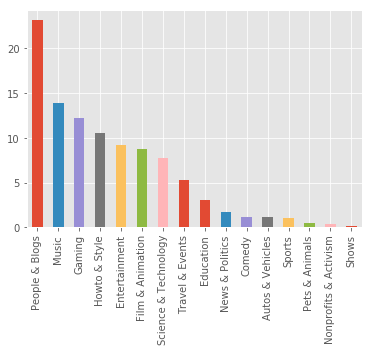

In [30]:
((affiliate_videos['categoryId'].value_counts() * 100) / len(affiliate_videos['categoryId'])).plot.bar()
plt.show()

#### Affiliate video creation time
How did these affiliate videos vary by year?

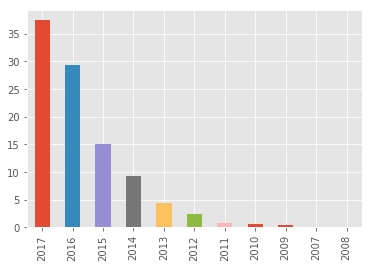

In [31]:
((affiliate_videos['publishedAt'].value_counts() * 100) / len(affiliate_videos['publishedAt'])).plot.bar()
plt.show()

#### Affiliate video countries

What are the affiliate video countries?

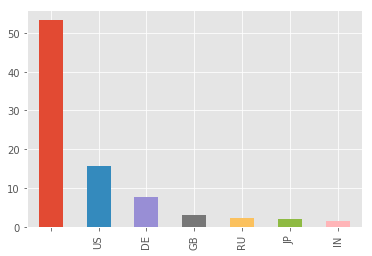

In [32]:
((affiliate_videos['channelCountry'].value_counts()[affiliate_videos['channelCountry'].value_counts() > 50] * 100) / len(affiliate_videos['channelCountry'])).plot.bar()
plt.show()

#### Affiliate video % by category
How did these affiliate videos vary as a function of the overall number of videos in each category?

In [33]:
((affiliate_videos['categoryId'].value_counts()*100)/video['categoryId'].value_counts()).sort_values(ascending=False)

Science & Technology     3.614779
Howto & Style            3.487491
Travel & Events          1.935146
Film & Animation         1.598860
Shows                    1.369863
Music                    0.945682
Entertainment            0.683546
Education                0.638104
Gaming                   0.634697
People & Blogs           0.390866
News & Politics          0.333736
Autos & Vehicles         0.296150
Pets & Animals           0.292713
Nonprofits & Activism    0.234101
Sports                   0.192339
Comedy                   0.190282
Movies                        NaN
Trailers                      NaN
Name: categoryId, dtype: float64

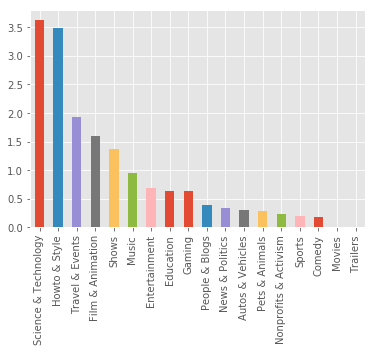

In [34]:
((affiliate_videos['categoryId'].value_counts()*100)/video['categoryId'].value_counts()).sort_values(ascending=False).plot.bar()
plt.show()

#### Affiliate video % by year
How did the year of these affiliate videos vary as a function of the number of overall videos in each year?

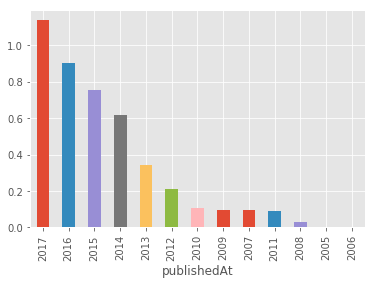

In [35]:
((affiliate_videos.groupby('publishedAt')['autoId'].count()*100) / video.groupby('publishedAt')['autoId'].count()).sort_values(ascending=False).plot.bar()
plt.show()

#### Affiliate video views
How do the views of the affiliate videos vary?

In [36]:
affiliate_videos['viewCount'].describe()

count    3.472000e+03
mean     3.127831e+05
std      3.151148e+06
min      0.000000e+00
25%      4.000000e+00
50%      1.460000e+02
75%      1.046300e+04
max      1.066066e+08
Name: viewCount, dtype: float64

Is this different from the non-affiliate videos?

In [37]:
non_affiliate_videos = video[~video['id'].isin(affiliate_urls['videoId'].tolist())].copy()
non_affiliate_videos['viewCount'].describe()

count    5.125270e+05
mean     2.896080e+04
std      9.798330e+05
min      0.000000e+00
25%      1.100000e+01
50%      4.900000e+01
75%      3.060000e+02
max      2.876380e+08
Name: viewCount, dtype: float64

In [41]:
dat_affiliate = utils.cdf(np.log10(affiliate_videos['viewCount'] + 1), 'viewCount')
dat_affiliate['Type'] = 'Affiliate videos'
dat_non_affiliate = utils.cdf(np.log10(non_affiliate_videos['viewCount'] + 1), 'viewCount')
dat_non_affiliate['Type'] = 'Non-affiliate videos'
dat_all = utils.cdf(np.log10(video['viewCount'] + 1), 'viewCount')
dat_all['Type'] = 'All'
dat = pd.concat([dat_affiliate, dat_non_affiliate, dat_all])

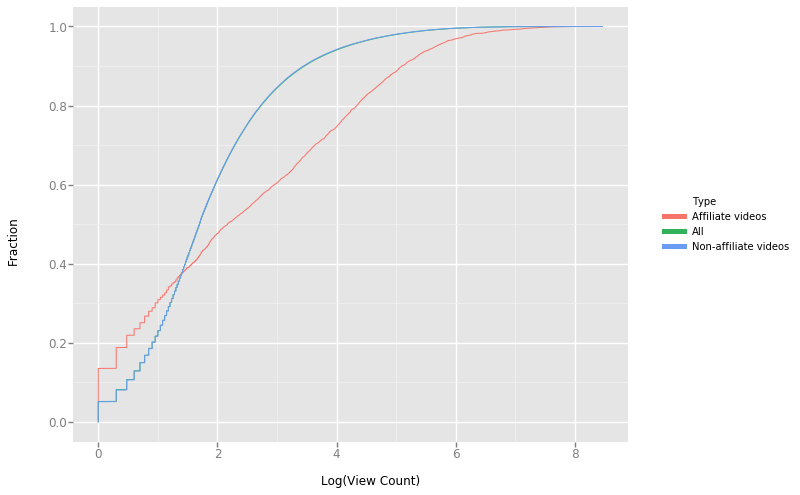

<ggplot: (459464533)>

In [42]:
ggplot(dat, aes(x = 'viewCount', y='Fraction', color='Type')) + geom_path() + xlab('Log(View Count)')

In [43]:
mannwhitneyu(affiliate_videos['viewCount'].tolist(), non_affiliate_videos['viewCount'].tolist())

MannwhitneyuResult(statistic=771575829.0, pvalue=6.752472902805625e-42)

Videos with affiliate links have significantly more views than those without.

#### Affiliate video duration
How do the duration of the affiliate videos vary?

In [44]:
affiliate_videos['duration'].describe()

count     3472.000000
mean       439.723502
std        922.603225
min          0.000000
25%         77.000000
50%        209.000000
75%        488.250000
max      24697.000000
Name: duration, dtype: float64

Is this different from the non-affiliate videos?

In [45]:
non_affiliate_videos['duration'].describe()

count    512527.000000
mean        445.911915
std        1203.003966
min           0.000000
25%          61.000000
50%         171.000000
75%         365.000000
max       86400.000000
Name: duration, dtype: float64

In [46]:
dat_affiliate = utils.cdf(np.log10(affiliate_videos['duration'] + 1), 'duration')
dat_affiliate['Type'] = 'Affiliate videos'
dat_non_affiliate = utils.cdf(np.log10(non_affiliate_videos['duration'] + 1), 'duration')
dat_non_affiliate['Type'] = 'Non-affiliate videos'
dat_all = utils.cdf(np.log10(video['duration'] + 1), 'duration')
dat_all['Type'] = 'All'
dat = pd.concat([dat_affiliate, dat_non_affiliate, dat_all])

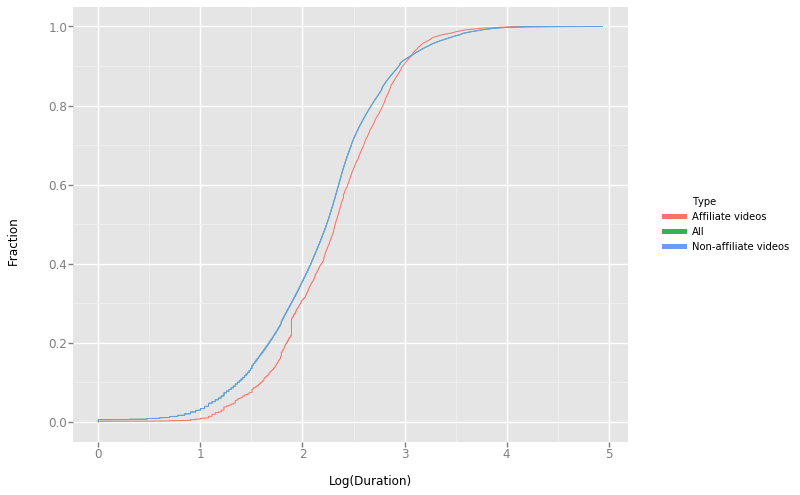

<ggplot: (459347705)>

In [47]:
ggplot(dat, aes(x = 'duration', y='Fraction', color='Type')) + geom_path() + xlab('Log(Duration)')

In [48]:
mannwhitneyu(affiliate_videos['duration'].tolist(), non_affiliate_videos['duration'].tolist())

MannwhitneyuResult(statistic=795138654.5, pvalue=1.45295438176669e-27)

Videos with affiliate links are significantly longer than those without. 

#### Affiliate video likes
How do the likes of the affiliate videos vary?

In [49]:
affiliate_videos['likeCount'].describe()

count      3472.000000
mean       2564.901786
std       19411.860729
min           0.000000
25%           0.000000
50%           2.000000
75%         179.000000
max      517739.000000
Name: likeCount, dtype: float64

Is this different from the non-affiliate videos?

In [50]:
non_affiliate_videos = video[~video['id'].isin(affiliate_urls['videoId'].tolist())]
non_affiliate_videos['likeCount'].describe()

count    512527.000000
mean        211.972171
std        4863.913527
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max      916814.000000
Name: likeCount, dtype: float64

In [51]:
dat_affiliate = utils.cdf(np.log10(affiliate_videos['likeCount'] + 1), 'likeCount')
dat_affiliate['Type'] = 'Affiliate videos'
dat_non_affiliate = utils.cdf(np.log10(non_affiliate_videos['likeCount'] + 1), 'likeCount')
dat_non_affiliate['Type'] = 'Non-affiliate videos'
dat_all = utils.cdf(np.log10(video['likeCount'] + 1), 'likeCount')
dat_all['Type'] = 'All'
dat = pd.concat([dat_affiliate, dat_non_affiliate, dat_all])

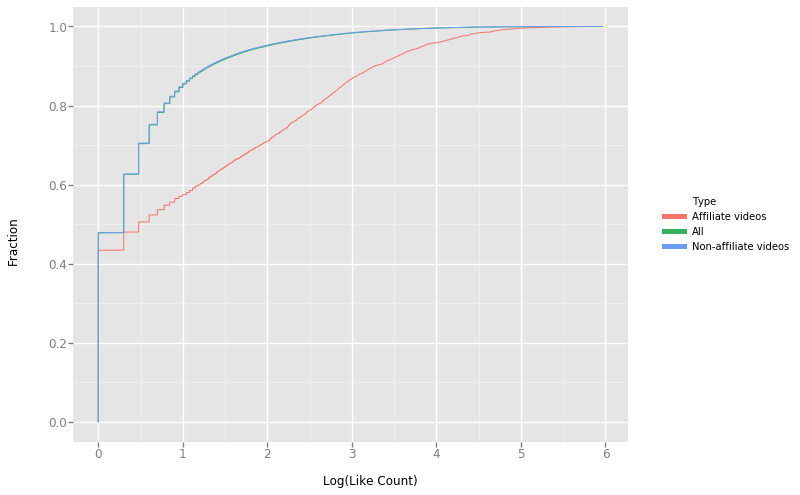

<ggplot: (459200169)>

In [52]:
ggplot(dat, aes(x = 'likeCount', y='Fraction', color='Type')) + geom_path() + xlab('Log(Like Count)')

In [53]:
mannwhitneyu(affiliate_videos['likeCount'].tolist(), non_affiliate_videos['likeCount'].tolist())

MannwhitneyuResult(statistic=696098700.0, pvalue=1.7007703225898032e-122)

Videos with affiliate links have significantly more likes than ones without. 

#### Affiliate video dislikes
How do the dislikes of the affiliate videos vary?

In [54]:
affiliate_videos['dislikeCount'].describe()

count     3472.000000
mean       127.872120
std       1338.174649
min          0.000000
25%          0.000000
50%          0.000000
75%          8.000000
max      60700.000000
Name: dislikeCount, dtype: float64

Is this different from the non-affiliate videos?

In [55]:
non_affiliate_videos = video[~video['id'].isin(affiliate_urls['videoId'].tolist())]
non_affiliate_videos['dislikeCount'].describe()

count    512527.000000
mean         12.538569
std         380.989172
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      128736.000000
Name: dislikeCount, dtype: float64

In [56]:
dat_affiliate = utils.cdf(np.log10(affiliate_videos['dislikeCount'] + 1), 'dislikeCount')
dat_affiliate['Type'] = 'Affiliate videos'
dat_non_affiliate = utils.cdf(np.log10(non_affiliate_videos['dislikeCount'] + 1), 'dislikeCount')
dat_non_affiliate['Type'] = 'Non-affiliate videos'
dat_all = utils.cdf(np.log10(video['dislikeCount'] + 1), 'dislikeCount')
dat_all['Type'] = 'All'
dat = pd.concat([dat_affiliate, dat_non_affiliate, dat_all])

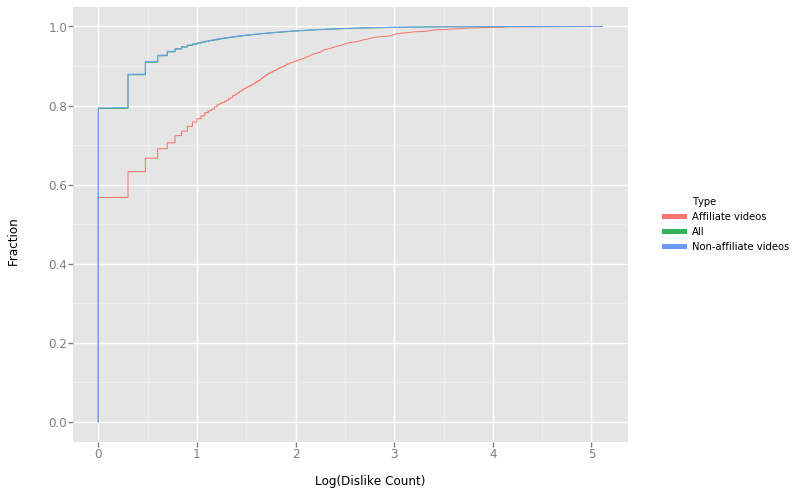

<ggplot: (459475225)>

In [57]:
ggplot(dat, aes(x = 'dislikeCount', y='Fraction', color='Type')) + geom_path() + xlab('Log(Dislike Count)')

In [58]:
mannwhitneyu(affiliate_videos['dislikeCount'].tolist(), non_affiliate_videos['dislikeCount'].tolist())

MannwhitneyuResult(statistic=651975914.0, pvalue=0.0)

Videos with affiliate links have significantly more dislikes than ones without. 

#### Affiliate video comments
How do the comments of the affiliate videos vary?

In [59]:
affiliate_videos['commentCount'].describe()

count      3472.000000
mean        336.700749
std        5147.470671
min           0.000000
25%           0.000000
50%           0.000000
75%          38.000000
max      285925.000000
Name: commentCount, dtype: float64

Is this different from the non-affiliate videos?

In [60]:
non_affiliate_videos = video[~video['id'].isin(affiliate_urls['videoId'].tolist())]
non_affiliate_videos['commentCount'].describe()

count    512527.000000
mean         26.056725
std         542.339765
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max      103048.000000
Name: commentCount, dtype: float64

In [61]:
dat_affiliate = utils.cdf(np.log10(affiliate_videos['commentCount'] + 1), 'commentCount')
dat_affiliate['Type'] = 'Affiliate videos'
dat_non_affiliate = utils.cdf(np.log10(non_affiliate_videos['commentCount'] + 1), 'commentCount')
dat_non_affiliate['Type'] = 'Non-affiliate videos'
dat_all = utils.cdf(np.log10(video['commentCount'] + 1), 'commentCount')
dat_all['Type'] = 'All'
dat = pd.concat([dat_affiliate, dat_non_affiliate, dat_all])

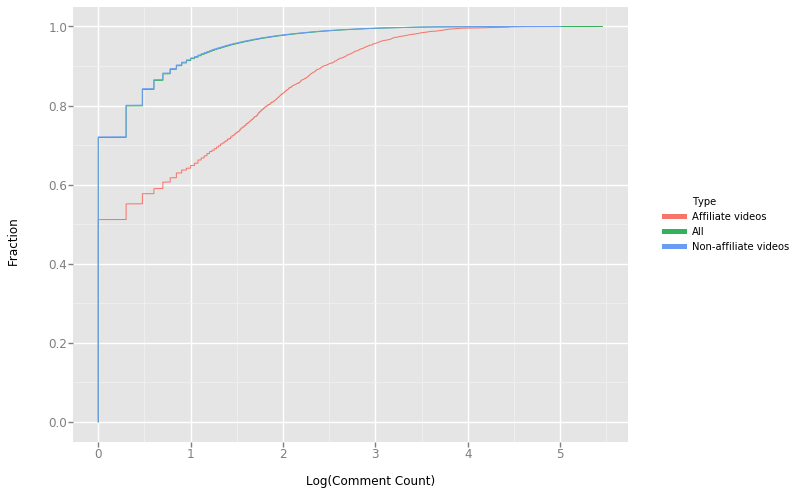

<ggplot: (459464665)>

In [62]:
ggplot(dat, aes(x = 'commentCount', y='Fraction', color='Type')) + geom_path() + xlab('Log(Comment Count)')

In [63]:
mannwhitneyu(affiliate_videos['commentCount'].tolist(), non_affiliate_videos['commentCount'].tolist())

MannwhitneyuResult(statistic=638757865.0, pvalue=1.2285114845545303e-287)

Videos with affiliate links have significantly more comments than ones without. 

### Examining the affiliate video descriptions

What languages are these descriptions in?

In [64]:
def get_language(x):
    language = 'Unknown'
    try:
        language = detect(x.description.strip())
    except:
        pass
    return language

affiliate_videos['description_language'] = affiliate_videos.apply(get_language, axis=1)
affiliate_videos['description_language'].value_counts()

en         2259
de          397
ru          286
ja          103
pt          102
es           69
fr           51
Unknown      50
it           38
fi           19
af           14
ca           13
sv           13
tr            9
id            7
uk            7
bg            7
th            5
nl            3
hu            2
tl            2
et            2
pl            2
ar            2
he            2
vi            1
cy            1
el            1
da            1
no            1
ko            1
hr            1
hi            1
Name: description_language, dtype: int64

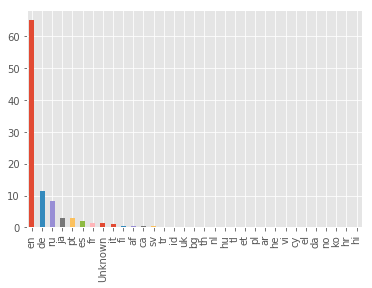

In [65]:
((affiliate_videos['description_language'].value_counts() * 100) / sum(affiliate_videos['description_language'].value_counts())).plot.bar()
plt.show()

How many lines do these descriptions contain?

In [66]:
affiliate_videos['description_line_count'] = affiliate_videos.apply(lambda x: len(x.description.splitlines()), axis=1)
affiliate_videos['description_line_count'].describe()

count    3472.000000
mean       21.915611
std        25.773722
min         1.000000
25%         3.000000
50%        14.000000
75%        32.000000
max       504.000000
Name: description_line_count, dtype: float64

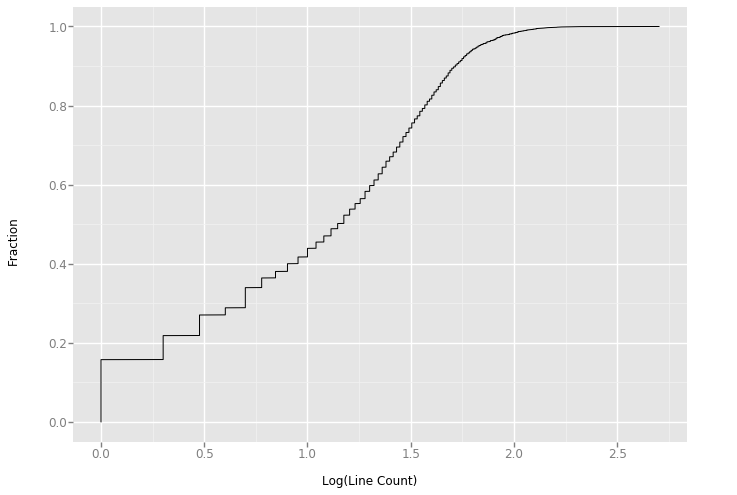

<ggplot: (458667625)>

In [67]:
dat = utils.cdf(np.log10(affiliate_videos['description_line_count']), 'description_line_count')
ggplot(dat, aes(x = 'description_line_count', y='Fraction')) + geom_path() + xlab('Log(Line Count)')

How many characters do these descriptions contain?

In [68]:
affiliate_videos['description_character_count'] = affiliate_videos.apply(lambda x: len(x.description) - x.description.count('\n') - x.description.count(' '), axis=1)
affiliate_videos['description_character_count'].describe()

count    3472.000000
mean      895.500000
std       863.866224
min        20.000000
25%       231.000000
50%       661.000000
75%      1262.000000
max      4411.000000
Name: description_character_count, dtype: float64

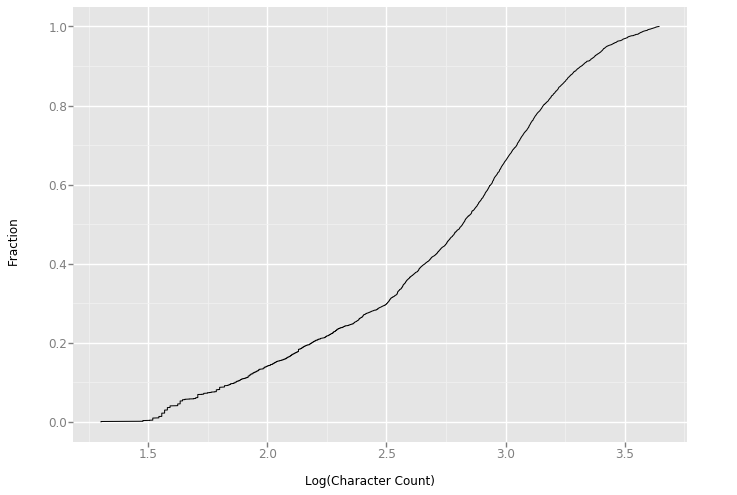

<ggplot: (458605609)>

In [69]:
dat = utils.cdf(np.log10(affiliate_videos['description_character_count']), 'description_character_count')
ggplot(dat, aes(x = 'description_character_count', y='Fraction')) + geom_path() + xlab('Log(Character Count)')

How many affiliate URLs are in each affiliate video?

In [70]:
list(affiliate_urls.columns.values)

['autoId', 'videoId', 'url', 'lineNumber']

In [71]:
affiliate_urls.groupby('videoId').count()['autoId'].describe()

count    3472.000000
mean        2.854839
std         4.467006
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        62.000000
Name: autoId, dtype: float64

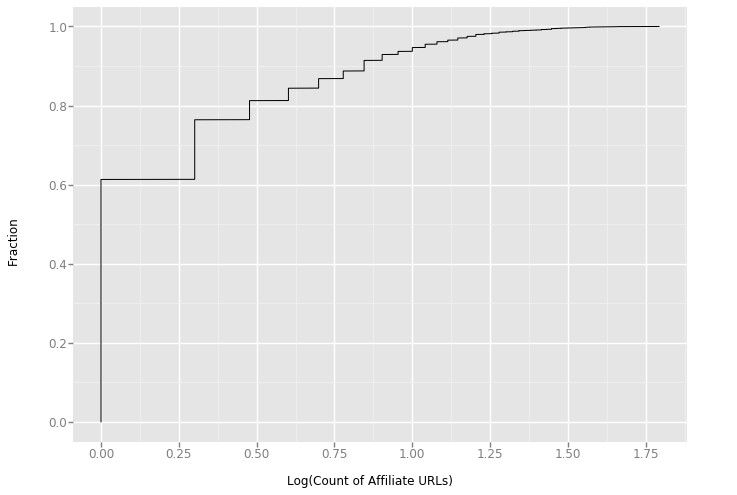

<ggplot: (458508297)>

In [72]:
dat = utils.cdf(np.log10(affiliate_urls.groupby('videoId').count()['autoId']), 'autoId')
ggplot(dat, aes(x = 'autoId', y='Fraction')) + geom_path() + xlab('Log(Count of Affiliate URLs)')

Moving forward, let's only examine the videos that contain descriptions in English.

In [73]:
affiliate_videos_en = affiliate_videos[affiliate_videos['description_language'] == 'en'].copy()

Next, let's cluster these by the sentences they contain. First, let's write routines to tokenize the sentences.

In [80]:
stemmer = PorterStemmer()

def tokenize(line):
    if (line is None):
        line = ''
    printable = set(string.printable)
    line = ''.join(filter(lambda x: x in printable, line)) 
    stopwords = nltk.corpus.stopwords.words('english')

    tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]*\'[a-zA-Z]*|\w+')
    
    tokens = []
    
    line = re.sub(r'(http[s]?://|www.)(?:[a-zA-Z]|[0-9]|[$-_@.&+]*|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))*', '', line).lower()
    tokens.extend(tokenizer.tokenize(line))
    
    tokens_ = [f.strip(string.punctuation) for f in tokens]
    tokens_ = [f for f in tokens_ if f != '' and f not in stopwords and len(f) != 1]
    tokens_ = [f for f in tokens_ if not (f.isdigit() or f[0] == '-' and f[1:].isdigit())]
    tokens_ = [stemmer.stem(f) for f in tokens_]

    return tokens_


Next, let's divide the documents into lines, and expand the dataframe.

In [81]:
# Add a sentence number value here
rows = []

def description_parse(desc):
    sentences = []
    for line in desc.splitlines():
        for sent in sent_tokenize(line):
            sentences.append(sent)
    
    return sentences

affiliate_videos_en.reset_index().apply(lambda row: [rows.append([row['id'], row['description'], sent])
                                       for sent in description_parse(row.description) if (len(tokenize(sent)) != 0)], axis = 1)
affiliate_videos_en_new = pd.DataFrame(rows, columns=['id', 'description', 'sentence'])

How many sentences do we have?

In [82]:
len(affiliate_videos_en_new.index)

36105

How many words do we have in each sentence?

In [83]:
affiliate_videos_en_new['sentence_word_count'] = affiliate_videos_en_new.apply(lambda x: len(x.sentence.split(' ')), axis=1)
affiliate_videos_en_new['sentence_word_count'].describe()

count    36105.000000
mean         8.371666
std         12.443537
min          1.000000
25%          3.000000
50%          5.000000
75%         10.000000
max        648.000000
Name: sentence_word_count, dtype: float64

Next, let's create a Tf-Idf representation of the lines.

In [84]:
countVec = CountVectorizer(tokenizer=tokenize, binary=True).fit(affiliate_videos_en_new['sentence'])

What is the size of the vocabulary?

In [85]:
len(countVec.vocabulary_)

20056

Let's create the bag of words representation.

In [86]:
lineVec = countVec.transform(affiliate_videos_en_new['sentence'])

Next, let's create the Tf-Idf representation.

In [87]:
tfidfTrans = TfidfTransformer().fit(lineVec)
tfIdfMatrix = tfidfTrans.transform(lineVec)

What is the size of the matrix?

In [88]:
tfIdfMatrix.shape

(36105, 20056)

From this Tf-Idf matrix, let's create a distance matrix to cluster the lines. We'll try several different approaches in heirarchial clustering.

#### Ward and Euclidean

First, let's compute the euclidean distance matrix from the above.

In [89]:
dist = euclidean_distances(lineVec)

Next, let's convert this to vector format. This is necessary as the linkage method below requires it in this format.

In [90]:
distVec = squareform(dist, checks = False)

Finally, let's cluster the lines.

In [91]:
res = fastcluster.linkage(distVec, method = 'ward', preserve_input = False)

Let's visualize the clusters.

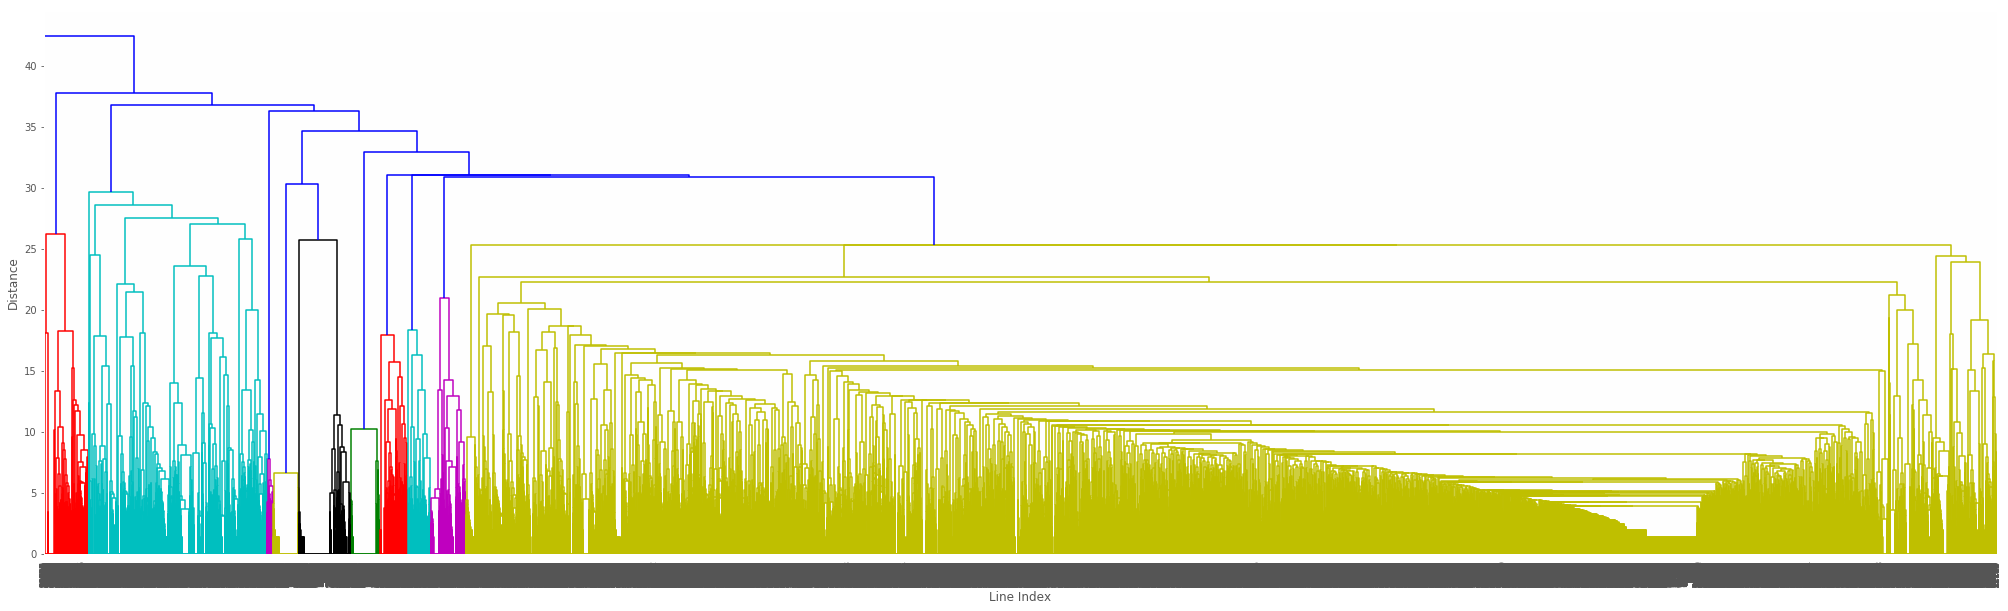

In [92]:
plt.figure(figsize=(35, 10))
plt.xlabel('Line Index')
plt.ylabel('Distance')
dendrogram(
    res,
    leaf_rotation=90.,  
    leaf_font_size=8.,  
)
plt.show()

Let's write the cluster numbers to a column in the data, and output the file.

In [93]:
affiliate_videos_en_new['ward_euclidean_cluster'] = fcluster(res, 5, criterion='distance')

In [94]:
#affiliate_videos_en_new.to_csv('clusters.csv', encoding='utf-8', columns=['id', 'sentence', 'ward_euclidean_cluster'], index=False)

### Mark the required disclosures

First, mark the affiliate disclosures

In [111]:
affiliate_videos_en_new['affiliate_link_disclosure'] = False
affiliate_videos_en_new.loc[affiliate_videos_en_new['ward_euclidean_cluster'].isin([372,382,383,384,385,388,389,390]), 'affiliate_link_disclosure'] = True

affiliate_videos_en_new['affiliate_link_expl_disclosure'] = False
affiliate_videos_en_new.loc[affiliate_videos_en_new['ward_euclidean_cluster'].isin([370,377,378,379,380,381,386,387]), 'affiliate_link_expl_disclosure'] = True

affiliate_videos_en_new['support_channel_disclosure'] = False
affiliate_videos_en_new.loc[affiliate_videos_en_new['ward_euclidean_cluster'].isin([363,364,366,367,368,369]), 'support_channel_disclosure'] = True

In [112]:
affiliate_videos_en['affiliate_link_disclosure'] = affiliate_videos_en.apply(lambda x: True if x.id in affiliate_videos_en_new[affiliate_videos_en_new['affiliate_link_disclosure'] == True]['id'].unique() else False, axis = 1)
affiliate_videos_en['affiliate_link_expl_disclosure'] = affiliate_videos_en.apply(lambda x: True if x.id in affiliate_videos_en_new[affiliate_videos_en_new['affiliate_link_expl_disclosure'] == True]['id'].unique() else False, axis = 1)
affiliate_videos_en['support_channel_disclosure'] = affiliate_videos_en.apply(lambda x: True if x.id in affiliate_videos_en_new[affiliate_videos_en_new['support_channel_disclosure'] == True]['id'].unique() else False, axis = 1)

In [113]:
affiliate_videos_en['affiliate_link_disclosure'].value_counts()

False    2092
True      158
Name: affiliate_link_disclosure, dtype: int64

In [114]:
affiliate_videos_en['affiliate_link_expl_disclosure'].value_counts()

False    2209
True       41
Name: affiliate_link_expl_disclosure, dtype: int64

In [115]:
affiliate_videos_en['support_channel_disclosure'].value_counts()

False    2195
True       55
Name: support_channel_disclosure, dtype: int64

In [123]:
affiliate_videos_en['disclosure_present'] = affiliate_videos_en.apply(lambda x: True if x.affiliate_link_disclosure == True or x.affiliate_link_expl_disclosure == True or x.support_channel_disclosure == True else False, axis = 1)
affiliate_videos_en['disclosure_present'].value_counts()

False    2014
True      236
Name: disclosure_present, dtype: int64

In [129]:
len(affiliate_videos_en[affiliate_videos_en['affiliate_link_disclosure'] == True]['channelId'].unique())

141

In [130]:
len(affiliate_videos_en[affiliate_videos_en['affiliate_link_expl_disclosure'] == True]['channelId'].unique())

39

In [132]:
len(affiliate_videos_en[affiliate_videos_en['support_channel_disclosure'] == True]['channelId'].unique())

45

In [133]:
len(affiliate_videos_en[affiliate_videos_en['disclosure_present'] == True]['channelId'].unique())

208

In [128]:
len(affiliate_videos_en['channelId'].unique())

1996

How do the disclosures vary by category?

In [138]:
dat = pd.DataFrame({'Count': affiliate_videos_en[affiliate_videos_en['disclosure_present'] == True]['categoryId'].value_counts(),
             'Total': affiliate_videos_en['categoryId'].value_counts(),
    'Influencer_Disclosing': affiliate_videos_en[affiliate_videos_en['disclosure_present'] == True][['categoryId','channelId']].groupby('categoryId').channelId.nunique(),
'Total_Influncers': affiliate_videos_en[['categoryId','channelId']].groupby('categoryId').channelId.nunique()})
dat['perc'] = (dat['Count'] * 100) / dat['Total']

In [139]:
dat.sort_values('Total', ascending = False)

,Count,Influencer_Disclosing,TOtal Influncers,Total,perc
People & Blogs,43,40,443,485,8.865979
Music,7,6,366,396,1.767677
Howto & Style,63,59,246,266,23.684211
Entertainment,24,21,207,214,11.214953
Gaming,23,21,152,205,11.219512
Film & Animation,9,9,143,185,4.864865
Travel & Events,7,7,150,170,4.117647
Science & Technology,14,13,133,144,9.722222
Education,10,10,56,58,17.241379
News & Politics,25,13,32,48,52.083333


How do the disclosures vary by year?

In [126]:
dat_year = pd.DataFrame({'number_affiliate': affiliate_videos_en['publishedAt'].value_counts(), 'number_disclosure': affiliate_videos_en[affiliate_videos_en['disclosure_present'] == True].groupby('publishedAt').size()})
dat_year['perc'] = (dat_year['number_disclosure'] * 100) / dat_year['number_affiliate']
dat_year[['number_disclosure', 'number_affiliate', 'perc']]

,number_disclosure,number_affiliate,perc
2007,2.0,5,40.000000
2008,NaN,3,NaN
2009,NaN,13,NaN
2010,4.0,18,22.222222
2011,1.0,23,4.347826
2012,4.0,64,6.250000
2013,11.0,112,9.821429
2014,18.0,206,8.737864
2015,45.0,357,12.605042
2016,76.0,615,12.357724
